In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

import seaborn as sns

# Relax data science challenge 

## 1 create target retention feature

## 2 EDA 

## 3 feature engineering

## 4 modeling / feature importance 



In [6]:
# load data
login = pd.read_csv('takehome_user_engagement.csv')
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [71]:
login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [72]:
login.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [7]:
## load login data

user = pd.read_csv('takehome_users.csv')
user.rename(columns={'object_id':'user_id'},inplace=True)
# create feature for if invited as not going to use every invited user id
user['invited']= np.where(user['invited_by_user_id'].notnull(),1,0)
user['invited'].value_counts()
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  invited                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [8]:
user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1


In [9]:
# no duplicates seen

user[user.duplicated(subset=['user_id'])]

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited


## get rid of columns not going to be used for model - NLP could be used on these to look for paterns in what email provider is correlated to retention but not for quick model

In [10]:

user.drop(columns=['name','email'],inplace=True)

## create column that shows how many people accepted invited from user 

In [11]:
user['invites_accepted']=user.groupby('invited_by_user_id')['user_id'].transform('count')
user['invites_accepted'].fillna(0,inplace=True)

In [12]:
user.nunique()

user_id                       12000
creation_time                 11996
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
invited                           2
invites_accepted                 14
dtype: int64

In [13]:
# keep invited by but put 0 instead of nan for invited
user['invited_by_user_id'].fillna(0,inplace=True)

In [14]:
## create integer of time since account creation

user['creation_time'] = pd.to_datetime(user['creation_time'],format='%Y-%m-%d')

user['days_since_creation'] = user['creation_time'].max() - user['creation_time']
user['days_since_creation'] = user['days_since_creation'].dt.days
user['creation_dayofweek']= user['creation_time'].dt.dayofweek
# convert to integer 
user['creation_time'] = user['creation_time'].dt.floor('d').astype(np.int64)
user['days_since_creation'].mean()

317.9429166666667

In [15]:
user.isnull().sum()

user_id                          0
creation_time                    0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
invited                          0
invites_accepted                 0
days_since_creation              0
creation_dayofweek               0
dtype: int64

## 1 Create target retention feature 
- steps - 

- making time stap a date time
- use groupby and rolling with 7d to count times visited per user id in 7 day window 
- filter for only 3 or more logins in 7 day mindow
- use final list of ids and np.where to add retained column to row if id is in list 

In [17]:
df = login.copy()
df.index = pd.to_datetime(df['time_stamp'])
grouped = df.groupby('user_id').rolling('7D')['visited'].count()
retained = grouped[grouped >=3]
retained

user_id  time_stamp         
2        2014-02-09 03:45:04    3.0
         2014-02-13 03:45:04    3.0
10       2013-02-19 22:08:03    3.0
         2013-03-02 22:08:03    3.0
         2013-03-05 22:08:03    3.0
                               ... 
11988    2014-05-23 11:04:47    6.0
         2014-05-24 11:04:47    6.0
         2014-05-26 11:04:47    5.0
         2014-05-27 11:04:47    5.0
         2014-06-01 11:04:47    3.0
Name: visited, Length: 160522, dtype: float64

In [18]:
## use set for no repeats
singles = set(retained.index.get_level_values('user_id'))
len(singles)

1602

In [19]:
user['retained'] = np.where(user['user_id'].isin(singles),1,0)

In [20]:
user['retained'].value_counts()

0    10398
1     1602
Name: retained, dtype: int64

# 2 EDA

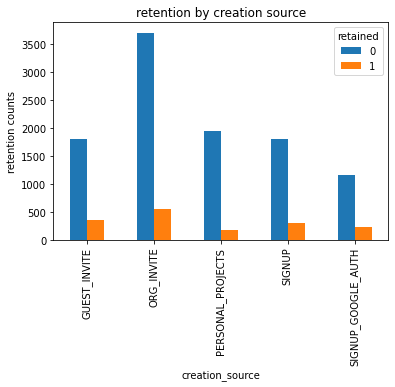

In [24]:
%matplotlib inline
pd.crosstab(user.creation_source,user['retained']).plot(kind='bar')
plt.title('retention by creation source')
plt.ylabel('retention counts')
plt.savefig('retention by creation source')

### Difference bewteen invite sources for retention look significant and could be explored further



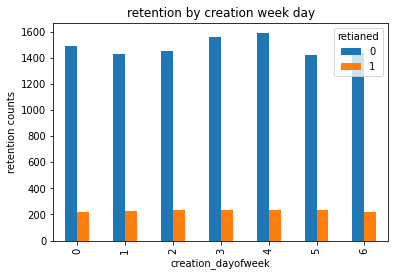

In [314]:
pd.crosstab(user.creation_dayofweek,user['retained']).plot(kind='bar')
plt.title('retention by creation week day')
plt.ylabel('retention counts')
plt.savefig('retention by creation week day')

### No major patern detected in day of the week

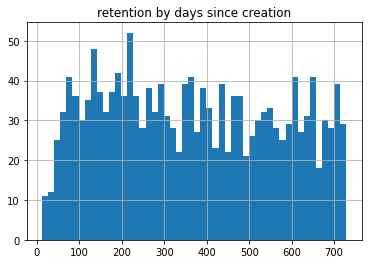

In [28]:
user[user['retained']==1]['days_since_creation'].hist(bins=50)
plt.title('retention by days since creation')
plt.show()

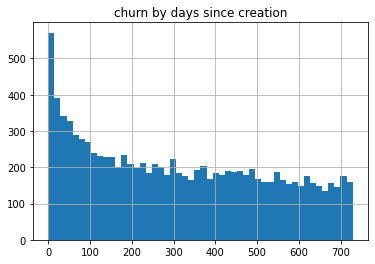

In [27]:
user[user['retaianed']==0]['days_since_creation'].hist(bins=50)
plt.title('churn by days since creation')
plt.show()

### Insight
- new users in the last 100 days show up at higher rates of churn compared to previous years. 
- this could highlight time taken to mature to retention or other problem to be explored. 

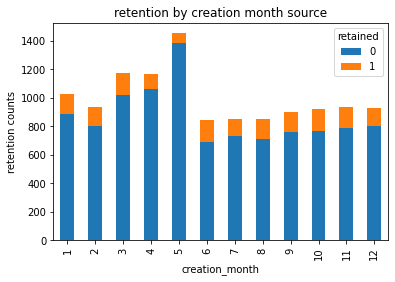

In [21]:
user['creation_time'] = pd.to_datetime(user['creation_time'])
user['creation_month'] = user['creation_time'].dt.month

pd.crosstab(user.creation_month,user['retained']).plot(kind='bar',stacked=True)
plt.title('retention by creation month source')

plt.ylabel('retention counts')
plt.savefig('retention by month')

### May has the most churn out of all months as well as the most accounts created - could be key time to focus on retention

# 3 feature engineering

## One hot encoding creation source 


In [22]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(user[['creation_source']]).toarray(),columns=['ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'])

enc_df
# # merge with main df bridge_df on key values
user = user.join(enc_df)
user.drop('creation_source',inplace=True,axis=1)
user.head()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,invites_accepted,days_since_creation,creation_dayofweek,retained,creation_month,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22,1.398139e+09,1,0,11,10803.0,1,1.0,38,1,0,4,0.0,0.0,0.0,0.0
1,2,2013-11-15,1.396238e+09,0,0,1,316.0,1,3.0,196,4,1,11,1.0,0.0,0.0,0.0
2,3,2013-03-19,1.363735e+09,0,0,94,1525.0,1,11.0,437,1,0,3,1.0,0.0,0.0,0.0
3,4,2013-05-21,1.369210e+09,0,0,1,5151.0,1,7.0,374,1,0,5,0.0,0.0,0.0,0.0
4,5,2013-01-17,1.358850e+09,0,0,193,5240.0,1,5.0,498,3,0,1,0.0,0.0,0.0,0.0


In [94]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   org_id                      12000 non-null  int64         
 5   invited_by_user_id          12000 non-null  float64       
 6   invited                     12000 non-null  int64         
 7   invites_accepted            12000 non-null  float64       
 8   days_since_creation         12000 non-null  int64         
 9   creation_dayofweek          12000 non-null  int64         
 10  retained                    12000 non-null  int64         
 11  creation_month              12000 non-null  int64     

In [23]:

## unable to convert to useful  time format so dropping
user.drop(columns=['last_session_creation_time'],inplace=True)

## Heat map of feature correlation 

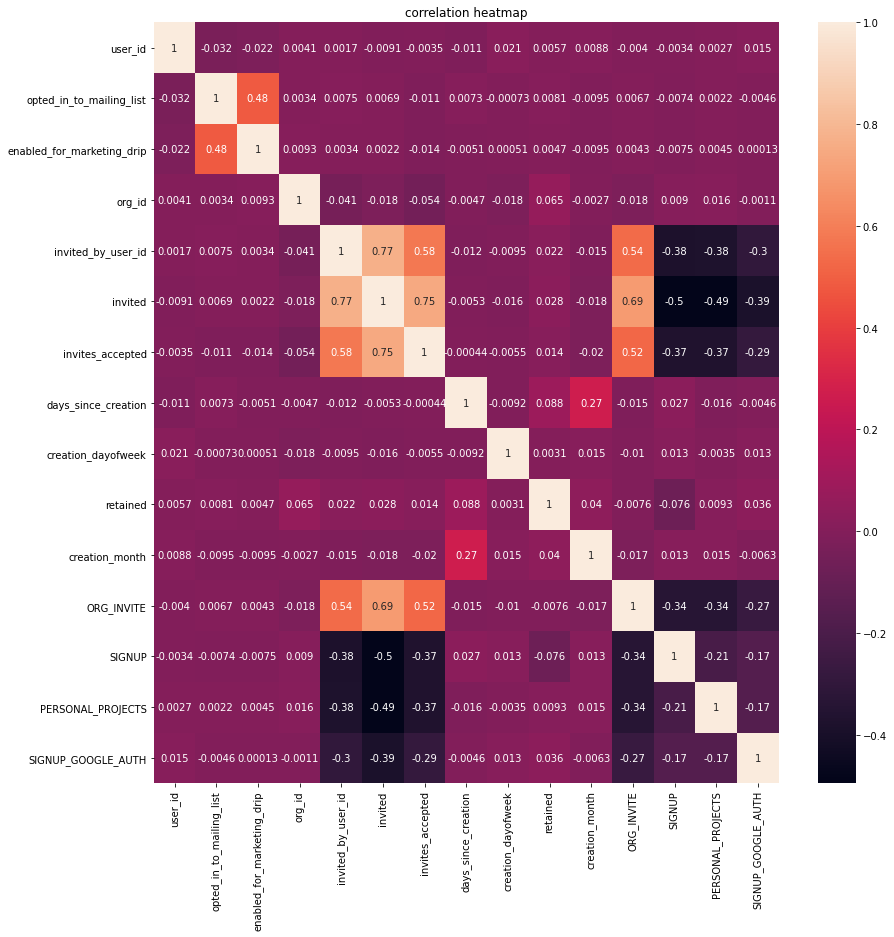

In [97]:
fig, ax = plt.subplots(figsize=(14,14))
ax = sns.heatmap(user.corr(),annot=True)
plt.title('correlation heatmap')
plt.show()

## Clear correlation between one hot encoded sign up options and target retention, need to drop days since creation as same as creation time.

# 4 Modeling

In [2]:
from imblearn.over_sampling import SMOTE


In [98]:
user['retained'].value_counts()

0    10398
1     1602
Name: retained, dtype: int64

In [78]:
X = user.drop(columns=['retained','user_id','creation_time', 'invited_by_user_id'])
print(X.shape)
y = user['retained']
print(y.shape)

(12000, 12)
(12000,)


In [172]:
def calc_prevalence(y):
 return (sum(y)/len(y))
calc_prevalence(user.retained)


0.1335

In [173]:

X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
# need to statisfy y as prevelance is 13 %
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                            random_state=0,stratify=y)
columns = X.columns


(12000, 12)


### To deal with inbalanced classes use smote to create synthic data points to train on  

## intial models with out smote made no false negative or true negative estimations , pour model removed after testing

In [175]:
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
print(os_data_X.shape,os_data_y.shape)

(16636, 12) (16636,)


In [164]:
print(X_test.shape,y_test.shape)

(2400, 12) (2400,)


In [176]:


def calc_specificity(y_actual, y_pred, thresh):
 # calculates specificity
 return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
 
 auc = roc_auc_score(y_actual, y_pred)
 accuracy = accuracy_score(y_actual, (y_pred > thresh))
 recall = recall_score(y_actual, (y_pred > thresh))
 precision = precision_score(y_actual, (y_pred > thresh))
 specificity = calc_specificity(y_actual, y_pred, thresh)
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)
 print('specificity:%.3f'%specificity)
 print('prevalence:%.3f'%calc_prevalence(y_actual))
 print(' ' )
#  return auc, accuracy, recall, precision, specificity

# Random Forest model 

In [184]:
# train on oversampled data set
rf=RandomForestClassifier(max_depth = 5, bootstrap=True,n_estimators=100, random_state = 42)
rf.fit(os_data_X,os_data_y)

RandomForestClassifier(max_depth=5, random_state=42)

In [178]:
y_pred = rf.predict(X_test)

In [179]:
confusion_matrix(y_test,y_pred)

array([[1104,  976],
       [ 108,  212]])

### only 212 out of 320 retentions were correctly labeled

### 976 samples were labeled as retention when they were actualy churn 


In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.53      0.67      2080
           1       0.18      0.66      0.28       320

    accuracy                           0.55      2400
   macro avg       0.54      0.60      0.48      2400
weighted avg       0.81      0.55      0.62      2400



### Model does not predict retention very well as has lots of false negatives missed by the model 

In [181]:
y_train_preds = rf.predict_proba(os_data_X)[:,1]
y_test_preds = rf.predict_proba(X_test)[:,1]

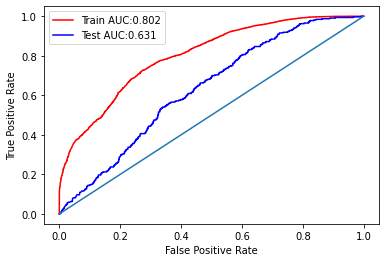

In [182]:

fpr_train, tpr_train, thresholds_train = roc_curve(os_data_y, y_train_preds)
auc_train = roc_auc_score(os_data_y, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_test_preds)
auc_valid = roc_auc_score(y_test, y_test_preds)
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Test AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

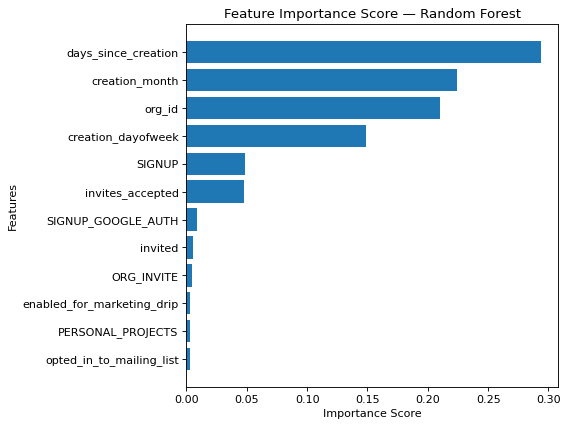

In [183]:
feature_importances = pd.DataFrame(rf.feature_importances_,
#  index = X_train.columns,
    index=columns,
                            
 columns=['importance']).sort_values('importance',
 ascending=False)
# num = min([50,len(X_train.columns)])
num = min([50,len(columns)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()


### days since creation, creation month, org id and creation day of the week all highlighted as key factors for the model. More tuning of model needed to help ensure best features used. 

## looks like generated features do have weight on model decision making 